In [1]:
#Import necessary packages
import math
import numpy as np
np.set_printoptions(suppress=True,
                    formatter={'all': lambda x: '%5.3f' % x})
import pandas as pd
from scipy.optimize import brute, fmin, minimize
import matplotlib.pyplot as plt
import matplotlib as mpl
mpl.rcParams['font.family'] = 'serif'

#Install import_ipynb so we can read dependenies as jupyter notebooks
!pip install ipynb

#Import dependencies
from ipynb.fs.full.Lewis_Integration_option_valuation import H93_call_value
from ipynb.fs.full.FFT_option_valuation_LEWIS import H93_call_value_FFT
from ipynb.fs.full.Vasicek_calibration import Vasicek_calibration , r_list 
from ipynb.fs.full.Vasicek_zcb_valuation import zcb_price  

In [2]:
#Import CSV file with option data as a panda dataframe
options = pd.read_csv('option_data.csv')
options

,Maturity,Strike,Call,Date,T,r
0,2021-01-08,85.0,13.500,2020-12-28,0.030137,-0.000491
1,2021-01-08,87.5,11.000,2020-12-28,0.030137,-0.000491
2,2021-01-08,90.0,8.500,2020-12-28,0.030137,-0.000491
3,2021-01-08,92.5,6.000,2020-12-28,0.030137,-0.000491
4,2021-01-08,95.0,3.900,2020-12-28,0.030137,-0.000491
...,...,...,...,...,...,...
125,2021-12-17,120.0,4.125,2020-12-28,0.969863,0.000721
126,2021-12-17,130.0,2.425,2020-12-28,0.969863,0.000721
127,2021-12-17,140.0,1.375,2020-12-28,0.969863,0.000721
128,2021-12-17,150.0,0.825,2020-12-28,0.969863,0.000721


In [8]:
##################################################################################################################
################################################ Preliminaries ###################################################

#Define Stock price (Ericsson B, 28.12.2020)               
S0 = 98.36   
#Dividend yield
d = 0.0086

#Slice the dataframe
#Default option selects all options in the csv file

##################################################################################################################
######################################## Loss Function for the calibration #######################################

i = 0                                                              #Initialize iteration counter
min_MSE = 500                                                      #Initial min_MSE value
def H93_error_function_LEWIS(p0):
    ''' Error function for parameter calibration in H93 model via
    Lewis (2001) Fourier approach.

    Parameters
    ==========
    kappa_v: float
        mean-reversion factor
    theta_v: float
        long-run mean of variance
    sigma_v: float
        volatility of variance
    rho: float
        correlation between variance and stock/index level
    v0: float
        initial, instantaneous variance

    Returns
    =======
    MSE: float
        mean squared error
    '''
    #kappa_v, theta_v, sigma_v, rho     , v0
    #a      , v_hat    eta      rho     , v
    global i, min_MSE                                           #Set global variables 
    kappa_v, theta_v, sigma_v, rho, v0 = p0                     #Define initial values of the parameter vector p0
    if kappa_v < 0.0 or theta_v < 0.005 or theta_v > 1.0 or sigma_v < 0.005 or sigma_v > 2.0 or rho < -1.0 or rho > 1.0:                       
        return 500.0
    if 2 * kappa_v * theta_v < sigma_v ** 2:      #Make sure that parameters adhere to their numerical boundaries
        return 500.0
    se = []
    delta = 2
    for row, option in options.iterrows():
        model_value = H93_call_value(S0, option['Strike'], option['T'],
                            option['r'], d, kappa_v, theta_v, sigma_v, rho, v0)
        se.append(delta**2 * (np.sqrt(1 + ((model_value - option['Call']) / delta)**2)) - 1)
    MSE = sum(se) / len(se)
    min_MSE = min(min_MSE, MSE)
    if i % 25 == 0:
        print('%4d |' % i, np.array(p0), '| %7.3f | %7.3f' % (MSE, min_MSE))
    i += 1
    return MSE

def H93_error_function_FFT(p0):
    ''' Error function for parameter calibration in H93 model via
    FFT approach.

    Parameters
    ==========
    kappa_v: float
        mean-reversion factor
    theta_v: float
        long-run mean of variance
    sigma_v: float
        volatility of variance
    rho: float
        correlation between variance and stock/index level
    v0: float
        initial, instantaneous variance

    Returns
    =======
    MSE: float
        mean squared error
    '''
    #kappa_v, theta_v, sigma_v, rho     , v0
    #a      , v_hat    eta      rho     , v
    global i, min_MSE                                           #Set global variables 
    kappa_v, theta_v, sigma_v, rho, v0 = p0                     #Define initial values of the parameter vector p0
    if kappa_v < 0.0 or theta_v < 0.005 or theta_v > 1.0 or sigma_v < 0.005 or sigma_v > 2.0 or rho < -1.0 or rho > 1.0:                       
        return 500.0
    if 2 * kappa_v * theta_v < sigma_v ** 2:      #Make sure that parameters adhere to their numerical boundaries
        return 500.0
    se = []
    delta = 2
    for row, option in options.iterrows():
        model_value = H93_call_value_FFT(S0, option['Strike'], option['T'],
                            option['r'], d, kappa_v, theta_v, sigma_v, rho, v0)
        se.append(delta**2 * (np.sqrt(1 + ((model_value - option['Call']) / delta)**2)) - 1)
    MSE = sum(se) / len(se)
    min_MSE = min(min_MSE, MSE)
    if i % 25 == 0:
        print('%4d |' % i, np.array(p0), '| %7.3f | %7.3f' % (MSE, min_MSE))
    i += 1
    return MSE

##################################################################################################################
################# Calibration of Heston (1993) parameters kappa_v, theta_v, sigma_v, rho, v0 #####################

def H93_calibration_full():
    ''' Calibrates H93 stochastic volatility model to market quotes. '''
    
    # Initial Parameter Guess
    p0 = [2, 0.3, 0.7, -0.3, 0.1]
    
    opt_lewis = fmin(H93_error_function_LEWIS, p0,  
                 xtol=0.001, ftol=0.001, 
                 maxiter=2000, maxfun=2000)
    
    opt_fft = fmin(H93_error_function_FFT, p0,  
                 xtol=0.001, ftol=0.001, 
                 maxiter=2000, maxfun=2000)
    
    return opt_lewis, opt_fft

##################################################################################################################
################### Calculation of Heston (1993) option values with stochastic interest rates  ######################

def H93_calculate_model_values(p0):
    ''' Calculates all model values given parameter vector p0. '''
    kappa_v, theta_v, sigma_v, rho, v0 = p0  
    values_lewis = []
    values_fft = []
    for row, option in options.iterrows():
        lewis_value = H93_call_value(S0, option['Strike'], option['T'],
                            option['r'], d, kappa_v, theta_v, sigma_v, rho, v0)
        fft_value = H93_call_value_FFT(S0, option['Strike'], option['T'],
                            option['r'], d, kappa_v, theta_v, sigma_v, rho, v0)
        values_lewis.append(lewis_value)
        values_fft.append(fft_value)
    return np.array(values_lewis), np.array(values_fft)

##################################################################################################################
################################################# Run calibration ################################################

if __name__ == '__main__': 
    
    #Run and print the calibration
    opt_lewis, opt_fft = H93_calibration_full()
    print('')
    print("Calibrated parameter vector with Lewis: ", opt_lewis)
    print("Calibrated parameter vector with FFT: ", opt_fft)

    #Create pandas column for Heston (1993) call options values based on calibrated data
    options['Model LEWIS'] = H93_calculate_model_values(opt_lewis)[0]
    options['Model FFT'] = H93_calculate_model_values(opt_fft)[1]

   0 | [2.000 0.300 0.700 -0.300 0.100] |   3.909 |   3.909
  25 | [2.171 0.190 0.823 -0.343 0.100] |   3.246 |   3.114
  50 | [2.725 0.112 0.732 -0.399 0.084] |   3.037 |   3.033
  75 | [2.619 0.114 0.723 -0.400 0.092] |   3.030 |   3.030
 100 | [2.528 0.115 0.745 -0.397 0.095] |   3.030 |   3.030
 125 | [2.515 0.113 0.753 -0.396 0.095] |   3.030 |   3.030
 150 | [2.510 0.114 0.756 -0.396 0.095] |   3.030 |   3.030
 175 | [2.475 0.115 0.753 -0.407 0.094] |   3.030 |   3.030
 200 | [2.445 0.116 0.751 -0.415 0.094] |   3.030 |   3.030
 225 | [2.440 0.116 0.751 -0.416 0.095] |   3.030 |   3.030
 250 | [2.439 0.116 0.751 -0.416 0.095] |   3.030 |   3.030
Optimization terminated successfully.
         Current function value: 3.029642
         Iterations: 186
         Function evaluations: 312
 275 | [2.142 0.195 0.805 -0.346 0.099] |  10.883 |   3.030
 300 | [2.354 0.139 0.781 -0.391 0.095] |  10.701 |   3.030
 325 | [2.518 0.115 0.730 -0.403 0.096] |  10.685 |   3.030
 350 | [2.287 0.117 

In [11]:
#Drop max.rows option so we can see full dataframe 
pd.set_option('display.max_rows', None)
options = options[abs(options['Call']-options['Model FFT'])<10]

# Compute relative error 
options['err FFT'] = abs(options['Call']-options['Model FFT'])/options['Call']
options['err LEWIS'] = abs(options['Call']-options['Model LEWIS'])/options['Call']
options

,Maturity,Strike,Call,Date,T,r,Model LEWIS,Model FFT,err FFT,err LEWIS
0,2021-01-08,85.0,13.500,2020-12-28,0.030137,-0.000491,13.347386,13.349731,0.011131,0.011305
1,2021-01-08,87.5,11.000,2020-12-28,0.030137,-0.000491,10.881366,10.887173,0.010257,0.010785
2,2021-01-08,90.0,8.500,2020-12-28,0.030137,-0.000491,8.476514,8.488989,0.001295,0.002763
3,2021-01-08,92.5,6.000,2020-12-28,0.030137,-0.000491,6.206139,6.228538,0.038090,0.034357
4,2021-01-08,95.0,3.900,2020-12-28,0.030137,-0.000491,4.182893,4.215725,0.080955,0.072537
5,2021-01-08,97.5,2.150,2020-12-28,0.030137,-0.000491,2.534320,2.572777,0.196641,0.178754
6,2021-01-08,100.0,0.900,2020-12-28,0.030137,-0.000491,1.347416,1.382652,0.536280,0.497129
7,2021-01-08,102.5,0.405,2020-12-28,0.030137,-0.000491,0.615772,0.640527,0.581548,0.520424
8,2021-01-08,105.0,0.405,2020-12-28,0.030137,-0.000491,0.238719,0.251871,0.378097,0.410570
9,2021-01-15,82.5,16.000,2020-12-28,0.049315,-0.000437,15.848235,15.852578,0.009214,0.009485


In [9]:
i = 0                                                              #Initialize iteration counter
min_MSE = 500                                                      #Initial min_MSE value
def H93_error_function_MSE(p0):
    ''' Error function for parameter calibration in BCC97 model via
    Lewis (2001) Fourier approach.

    Parameters
    ==========
    kappa_v: float
        mean-reversion factor
    theta_v: float
        long-run mean of variance
    sigma_v: float
        volatility of variance
    rho: float
        correlation between variance and stock/index level
    v0: float
        initial, instantaneous variance

    Returns
    =======
    MSE: float
        mean squared error
    '''
    global i, min_MSE                                           #Set global variables 
    kappa_v, theta_v, sigma_v, rho, v0 = p0                     #Define initial values of the parameter vector p0
    
    se = []
    err =[]
    for row, option in options.iterrows():
        model_value = H93_call_value(S0, option['Strike'], option['T'],
                            option['r'], d, kappa_v, theta_v, sigma_v, rho, v0)
        se.append((model_value - option['Call']) ** 2)
        err.append(abs(model_value - option['Call']))
    MSE = sum(se) / len(se)
    min_MSE = min(min_MSE, MSE)
    abs_err = sum(err)/len(err)
    if i % 25 == 0:
        print('%4d |' % i, np.array(p0), '| %7.3f | %7.3f' % (MSE, min_MSE))
    i += 1
    return MSE, abs_err
H93_error_function_MSE([2.438, 0.116, 0.751, -0.416, 0.095])

   0 | [2.438 0.116 0.751 -0.416 0.095] |   0.060 |   0.060


(0.06014088223555413, 0.1881049016453929)

In [12]:
maturities=list(set(options['T']))
maturities[4]

0.2219178082191781

In [13]:
plot = options[options['T']==maturities[4]]
plot

,Maturity,Strike,Call,Date,T,r,Model LEWIS,Model FFT,err FFT,err LEWIS
51,2021-03-19,42.0,56.250,2020-12-28,0.221918,-0.000032,56.172519,56.172763,0.001373,0.001377
52,2021-03-19,46.0,52.250,2020-12-28,0.221918,-0.000032,52.173274,52.173672,0.001461,0.001468
53,2021-03-19,50.0,48.250,2020-12-28,0.221918,-0.000032,48.175348,48.176109,0.001531,0.001547
54,2021-03-19,54.0,44.250,2020-12-28,0.221918,-0.000032,44.180446,44.181992,0.001537,0.001572
55,2021-03-19,58.0,40.250,2020-12-28,0.221918,-0.000032,40.191925,40.195023,0.001366,0.001443
56,2021-03-19,62.0,36.250,2020-12-28,0.221918,-0.000032,36.215931,36.221857,0.000776,0.000940
57,2021-03-19,66.0,32.250,2020-12-28,0.221918,-0.000032,32.262971,32.273664,0.000734,0.000402
58,2021-03-19,70.0,28.500,2020-12-28,0.221918,-0.000032,28.349945,28.368080,0.004629,0.005265
60,2021-03-19,80.0,19.000,2020-12-28,0.221918,-0.000032,18.937692,18.989112,0.000573,0.003279
61,2021-03-19,85.0,14.875,2020-12-28,0.221918,-0.000032,14.604427,14.678299,0.013224,0.018190


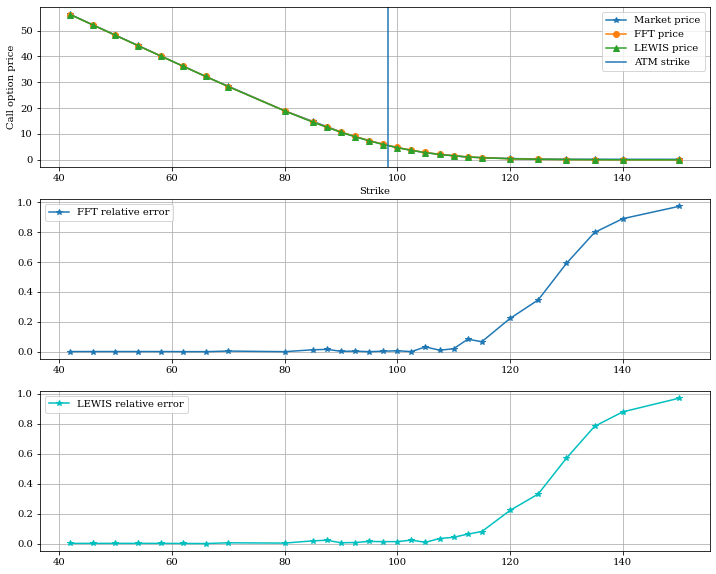

In [30]:
plt.figure(figsize=(12, 10))
plt.subplot(311) 
plt.plot(plot['Strike'], plot['Call'],'-*',label = 'Market price')
plt.plot(plot['Strike'], plot['Model FFT'],'-o',label = 'FFT price')
plt.plot(plot['Strike'], plot['Model LEWIS'],'-^',label = 'LEWIS price')
plt.axvline(x=S0,label='ATM strike')
plt.xlabel('Strike')
plt.ylabel('Call option price')
plt.grid()
plt.legend()

plt.subplot(312)
plt.plot(plot['Strike'], plot['err FFT'],'-*',label = 'FFT relative error')
plt.legend()
plt.grid()


plt.subplot(313)
plt.plot(plot['Strike'], plot['err LEWIS'],'-*',color = 'c' ,label = 'LEWIS relative error')
plt.legend()
plt.grid()
plt.show()

In [41]:
tol = 0.1 # percent ITM/OTM options
options_atm = options.loc[(np.abs(options['Strike'] - S0) / S0) < tol]
options_atm = options_atm[options_atm['T']==maturities[4]]
options_atm

,Maturity,Strike,Call,Date,T,r,Model LEWIS,Model FFT,err FFT,err LEWIS
63,2021-03-19,90.0,10.750,2020-12-28,0.221918,-0.000032,10.689918,10.783764,0.003141,0.005589
64,2021-03-19,92.5,9.000,2020-12-28,0.221918,-0.000032,8.936296,9.036543,0.004060,0.007078
65,2021-03-19,95.0,7.450,2020-12-28,0.221918,-0.000032,7.342304,7.445039,0.000666,0.014456
66,2021-03-19,97.5,6.000,2020-12-28,0.221918,-0.000032,5.922616,6.023088,0.003848,0.012897
67,2021-03-19,100.0,4.750,2020-12-28,0.221918,-0.000032,4.687052,4.780257,0.006370,0.013252
68,2021-03-19,102.5,3.725,2020-12-28,0.221918,-0.000032,3.638754,3.720231,0.001280,0.023153
69,2021-03-19,105.0,2.750,2020-12-28,0.221918,-0.000032,2.773010,2.839645,0.032598,0.008367
70,2021-03-19,107.5,2.150,2020-12-28,0.221918,-0.000032,2.077282,2.127829,0.010312,0.033823


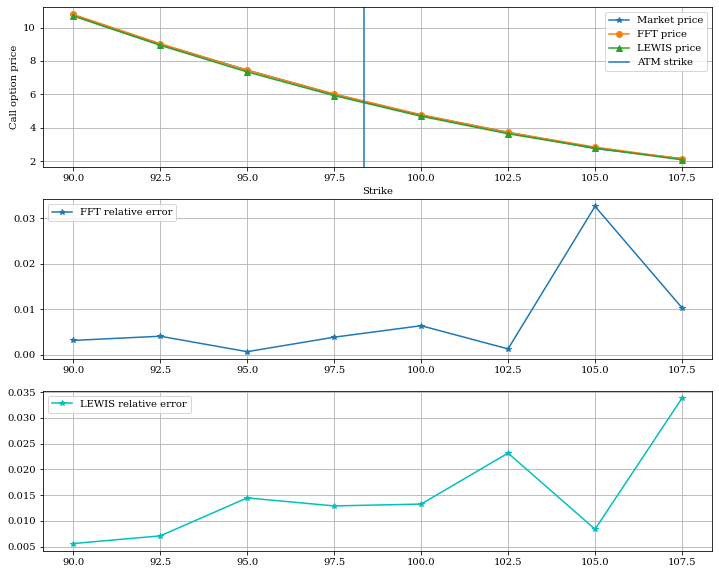

In [43]:
plt.figure(figsize=(12, 10))
plt.subplot(311) 
plt.plot(options_atm['Strike'], options_atm['Call'],'-*',label = 'Market price')
plt.plot(options_atm['Strike'], options_atm['Model FFT'],'-o',label = 'FFT price')
plt.plot(options_atm['Strike'], options_atm['Model LEWIS'],'-^',label = 'LEWIS price')
plt.axvline(x=S0,label='ATM strike')
plt.xlabel('Strike')
plt.ylabel('Call option price')
plt.grid()
plt.legend()

plt.subplot(312)
plt.plot(options_atm['Strike'], options_atm['err FFT'],'-*',label = 'FFT relative error')
plt.legend()
plt.grid()


plt.subplot(313)
plt.plot(options_atm['Strike'], options_atm['err LEWIS'],'-*',color = 'c' ,label = 'LEWIS relative error')
plt.legend()
plt.grid()
plt.show()